# Imports

In [2]:
import cv2
from PIL import Image
from sklearn.cluster import BisectingKMeans
import numpy as np
import pandas as pd
import gc
from sklearn.cluster import KMeans
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import glob
from pprint import pprint
from typing import Literal
import xml.etree.ElementTree as ET

# Segmentation

### Class Definitions

In [3]:
class utils:
    @staticmethod
    def get_paths_by_re(base_directory, regular_expression):
        search_pattern = os.path.join(base_directory, regular_expression)
        # Use glob to find all files matching the pattern
        png_files = glob.glob(search_pattern, recursive=True)
        return png_files


In [58]:
class Display:
    @staticmethod
    def overlay_segmentation_mask(image, mask, color=(0, 0, 255), alpha=0.5):
        """
        Overlay a binary segmentation mask on an image with a translucent colored layer.

        Parameters:
            image_path (str): Path to the input image.
            mask_path (str): Path to the binary segmentation mask image.
            color (tuple): Color of the overlay in BGR format.
            alpha (float): Opacity of the overlay.

        Returns:
            np.array: Image with the overlay.
        """
        mask = mask > 0
        if len(image.shape) == 2 or image.shape[2] == 1:
            image = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)
        overlay = np.zeros_like(image, dtype=np.uint8)
        overlay[:] = color
        blended = image.copy()
        blended[mask] = cv2.addWeighted(image, 1 - alpha, overlay, alpha, 0)[mask]
        return blended
    



In [4]:
class ImageSliceExtractor:
    NAMESPACES = {
        "pds": "http://pds.nasa.gov/pds4/pds/v1",
        "isda": "https://isda.issdc.gov.in/pds4/isda/v1",
    }

    def __init__(self, image_path: str, xml_path: str, preview_path: str = None): 
        self.xml_path = xml_path
        self.image_path = image_path
        self.height, self.width = ImageSliceExtractor.extract_image_shape(xml_path)
        self.preview_path = preview_path

    def preview(self):
        return Image.open(self.preview_path) if self.preview_path else print("Image preview path not provided")

    @classmethod
    def extract_image_shape(cls, xml_file_path) -> tuple[int, int]:
        tree = ET.parse(xml_file_path)
        root = tree.getroot()
        element_tag = root.findall(".//pds:elements", cls.NAMESPACES)

        shape = []
        for element in element_tag:
            shape.append(int(element.text))

        return shape

    def extract_slice(self, x=None, y=None, slice_width=None, slice_height=None):
        """
        file_path : Path of the image File
        width : width of the image
        height : height of the image
        x : x coordinate from where you want to slice
        y : y coordinate from where you want to slice
        slice_width : width of the slice
        slice_height : height of the slice
        """
        # Adjust slice_width and slice_height if they extend beyond image boundaries
        if x + slice_width > self.width:
            raise Exception("Slice width out of bound")
        if y + slice_height > self.height:
            raise Exception("Slice height out of bound")

        # Initialize the slice array
        slice_array = np.zeros((slice_height, slice_width), dtype=np.uint8)

        with open(self.image_path, "rb") as f:
            for row in range(slice_height):
                # Calculate the position to seek in the file
                pos = (y + row) * self.width + x
                f.seek(pos)
                # Read the slice_width bytes for the current row
                row_data = f.read(slice_width)
                # Store the row data in the numpy array
                slice_array[row, :] = np.frombuffer(row_data, dtype=np.uint8)
        return slice_array

In [88]:
class Segmenter:
    def __init__(
        self,
        image: np.ndarray,
        white_threshold = 230, 
        black_threshold = 25
    ):
        self.image = image.reshape(image.shape[0], image.shape[1], 1)
        self.white_threshold = white_threshold
        self.black_threshold = black_threshold


    
    def segment(self):
        result = self.intensity_rescaling(self.image)
        white_mask = result.get('white_mask')
        black_mask = result.get('black_mask')
        white_mask, black_mask = self.get_masks(white_mask, black_mask)
        gc.collect()
        print(white_mask.shape)
        self.white_mask = self.erosion_and_dialation_using_stream(white_mask, "EEDDD", kernel=self.get_elliptic_element(3, 2))
        self.black_mask = self.erosion_and_dialation_using_stream(black_mask, "EEDDD", kernel=self.get_elliptic_element(3, 2))
        self.combined_mask = np.maximum(white_mask, black_mask)
        return self.combined_mask

    def get_masks(self, white_mask, black_mask):
        thresholded_white = (white_mask >= self.white_threshold) * np.uint8(255)
        del white_mask
        thresholded_black = (black_mask <= self.black_threshold) * np.uint8(255)
        del black_mask
        return thresholded_white, thresholded_black
    
    def intensity_rescaling(self, img_slice, max_size=1000):
        img_slice = self.resize_image_with_aspect_ratio(img_slice, max_size=max_size)
        eroded_img_black = self.erosion_and_dialation_using_stream(
            img_slice, stream="E", iterations=1, kernel=self.get_elliptic_element(3, 2)
        )
        dilated_img_white = self.erosion_and_dialation_using_stream(
            img_slice, stream="D", iterations=1, kernel=self.get_elliptic_element(3, 2)
        )

        rescaled_img_white, min_val, max_val = self.adaptive_intensity_scaling(
            dilated_img_white, quantiles=[0.01, 0.99], rescale=True, ret_thresholds=True
        )
        clahe_adapted_white = cv2.createCLAHE(
            clipLimit=5.0, tileGridSize=(10, 10)
        ).apply(rescaled_img_white)
        bias_adaption_white, min_val, max_val = self.adaptive_intensity_scaling(
            clahe_adapted_white,
            quantiles=[0.01, 0.99],
            rescale=True,
            ret_thresholds=True,
        )

        rescaled_img_black, min_val, max_val = self.adaptive_intensity_scaling(
            eroded_img_black, quantiles=[0.01, 0.99], rescale=True, ret_thresholds=True
        )
        clahe_adapted_black = cv2.createCLAHE(
            clipLimit=5.0, tileGridSize=(10, 10)
        ).apply(rescaled_img_black)
        bias_adaption_black, min_val, max_val = self.adaptive_intensity_scaling(
            clahe_adapted_black,
            quantiles=[0.01, 0.99],
            rescale=True,
            ret_thresholds=True,
        )
        return {
            "white_mask": bias_adaption_white,
            "black_mask": bias_adaption_black,
        }

    def erosion_and_dialation_using_stream(
        self, img, stream="", iterations=1, kernel=(3,3)
    ):
        output = img.copy()
        for i in stream:
            if i == "D":
                output = cv2.dilate(output, kernel, iterations=iterations)
            else:
                output = cv2.erode(output, kernel, iterations=iterations)
        return output

    def get_elliptic_element(self, erosion_size, shape=2):
        return cv2.getStructuringElement(
            shape,
            (2 * erosion_size + 1, 2 * erosion_size + 1),
            (erosion_size, erosion_size),
        )

    def resize_image_with_aspect_ratio(self,image, max_size=1200):
        h, w = image.shape[:2]

        # Determine the scale factor and new dimensions
        if h > w:
            scale_factor = max_size / h
            new_h = max_size
            new_w = int(w * scale_factor)
        else:
            scale_factor = max_size / w
            new_w = max_size
            new_h = int(h * scale_factor)

        # Resize the image
        resized_image = cv2.resize(image, (new_w, new_h))
        return resized_image

    def adaptive_intensity_scaling(
        self,
        image: np.ndarray[np.uint8],
        epsilon=0.0001,
        quantiles: tuple[int, int] = (0.25, 0.95),
        rescale=False,
        ret_thresholds=False,
    ) -> np.ndarray[np.uint8]:
        """
        Adaptively rescales the brightness of the image by performing min max scaling between the
        -quantiles[0]% quantile value (value which is greater than quantiles[0]% of all values present)
        and
        -quantiles[1]% quantile value (value which is greater than quantiles[1]% of all values present)
        epsilon is a small constant added to prevent zero division error when min max scaling
        """
        image_reciprocated = image.astype(np.float64)
        min_val, max_val = np.quantile(image_reciprocated.flatten(), quantiles)
        image_reciprocated[image_reciprocated < min_val] = min_val
        image_reciprocated[image_reciprocated > max_val] = max_val
        if rescale:
            image_reciprocated = (image_reciprocated - image_reciprocated.min()) / (
                image_reciprocated.max() - image_reciprocated.min() + epsilon
            )
            image_reciprocated = image_reciprocated * 255

        if ret_thresholds:
            return image_reciprocated.astype(np.uint8), min_val, max_val
        return image_reciprocated.astype(np.uint8)


### Getting File Paths

In [6]:
# Get directory list

bin_image_paths = utils.get_paths_by_re('/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/','*/dataset/*/data/calibrated/*/*.img')
xml_paths = utils.get_paths_by_re('/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/','*/dataset/*/data/calibrated/*/*.xml')
preview_paths = utils.get_paths_by_re('/kaggle/input/isro-chandrayan-ohrc-dataset/other/dataset/','*/dataset/*/browse/calibrated/*/*.png')
bin_image_paths.sort()
xml_paths.sort()
preview_paths.sort()


### Image Slice Extractor

In [28]:
extractor = ImageSliceExtractor(
  image_path=bin_image_paths[0],
  xml_path=xml_paths[0],
  preview_path=preview_paths[0]
)

In [29]:
image_slice = extractor.extract_slice(0,0, 1000, 1000)

In [89]:
segmenter = Segmenter(image_slice)
segment_result = segmenter.segment()

(1000, 1000)


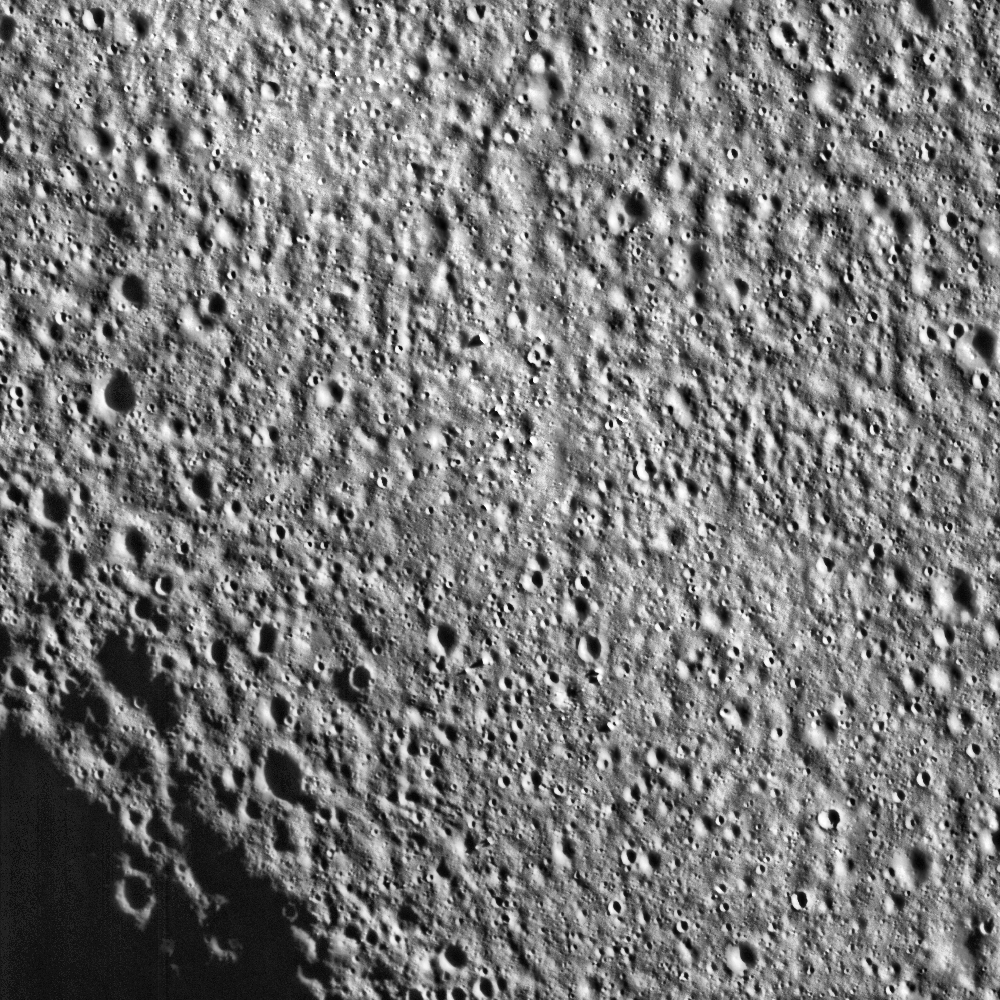

In [81]:
clahe = cv2.createCLAHE(
            clipLimit=7.0, tileGridSize=(2, 2)
        ).apply(image_slice)
clahe = cv2.createCLAHE(
            clipLimit=6.0, tileGridSize=(50, 50)
        ).apply(image_slice)
Image.fromarray(clahe)

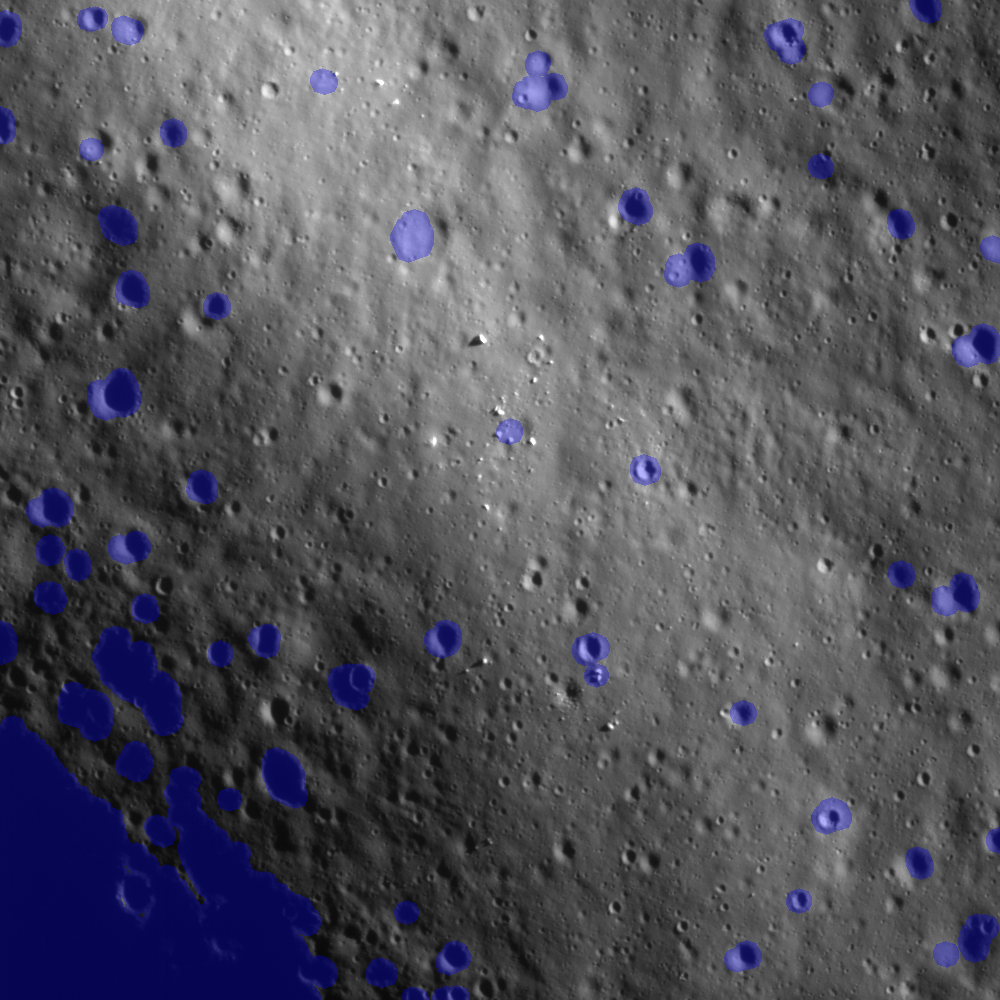

In [109]:
Image.fromarray(Display.overlay_segmentation_mask(image_slice, new_mask, alpha = 0.3))

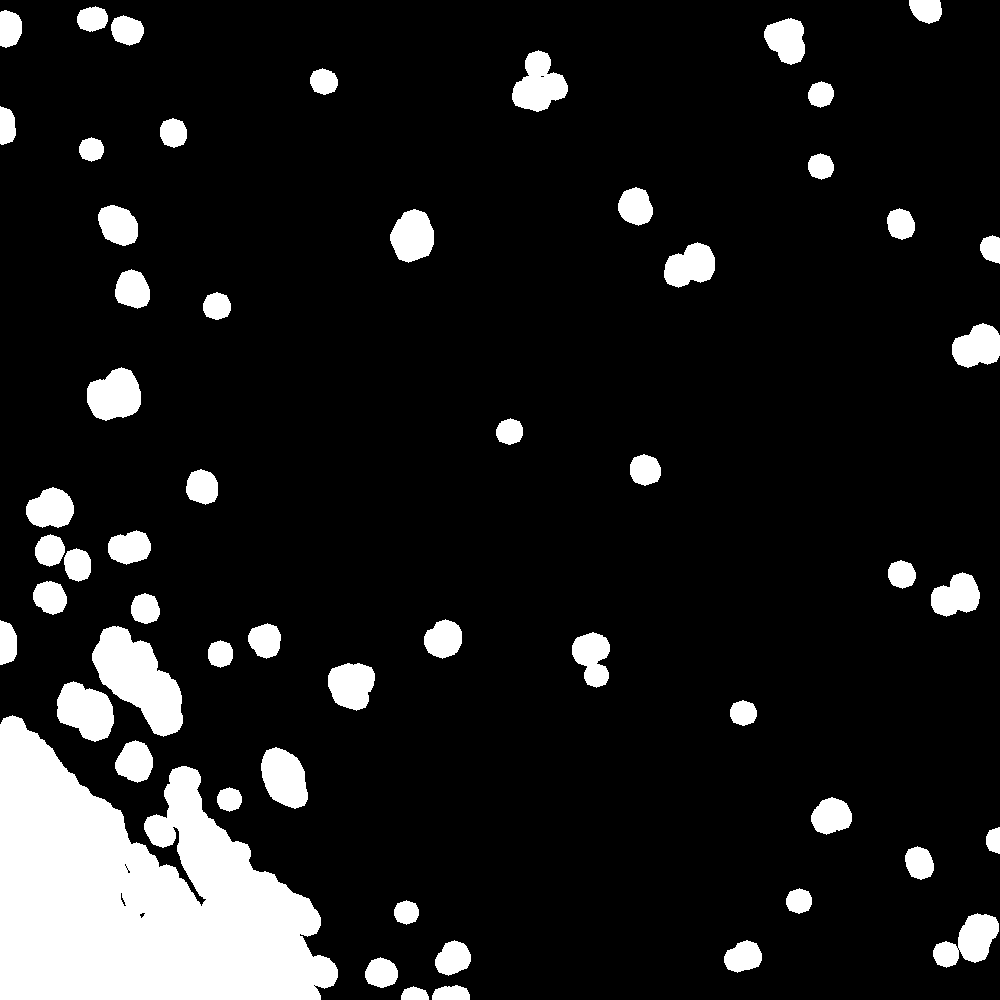

In [108]:
new_mask = segmenter.erosion_and_dialation_using_stream(segment_result, "EEDDD", iterations=1, kernel=segmenter.get_elliptic_element(4,2))
Image.fromarray(new_mask)

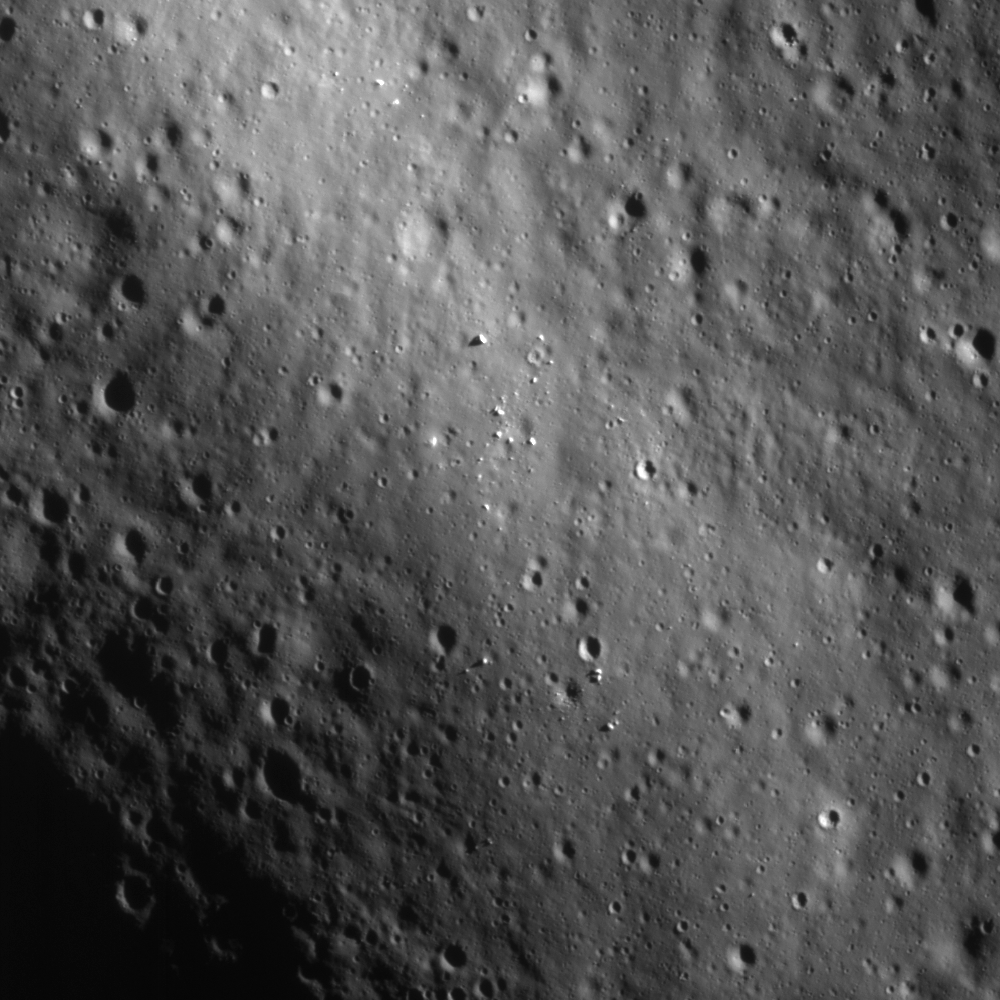

In [65]:
Image.fromarray(image_slice)